# Лабораторная работа 6. Рекуррентные сети

В работе демонстрируется построение рекуррентной нейронной сети для посимвольной генерации текста.  

Полезные ссылки:
- [Andrej Karpathy – The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness)
- [Practical PyTorch: Generating Shakespeare with a Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)
- [С. Николенко и др., 2018] – параграф 6.6.

In [1]:
import torch
import torch.nn as nn
import random
import time
import math
import matplotlib.pyplot as plt

Задаем параметры:

In [2]:
filename = 'onegin.txt'  # Входной файл с текстом

seq_len = 200            # Размер последовательности для одной эпохи
batch_size_train = 1     # Размер батча для обучения
batch_size_test = 1      # Размер батча для предсказания (в данном случае всегда 1)
hidden_size = 100        # Размер скрытого состояния
embedding_size = 100     # Размер векторов-эмбеддингов для представления символов
num_layers = 1           # Количество слоев
lr = 0.005               # Скорость обучения
n_epochs = 1000          # Количество эпох
print_every = 100        # Интервал эпох для вывода результатов
plot_every = 10          # Интервал эпох для вывода потерь
predict_len = 100        # Количество символов для генерации

*Замечание*. Понятие "эпоха" обозначает период обработки всего обучающего множества. Но в контексте рекуррентных сетей это понятие может иметь значение, отличающееся от обычного, поскольку часто датасет бывает жестко не определен (например, из одного текста мы можем генерировать бесконечное количество последовательностей).  
Поэтому в данной лабораторной работе понятие "эпоха" обозначает период обработки всей последовательности размером `seq_len`.

Обеспечиваем воспроизводимость результатов (https://pytorch.org/docs/stable/notes/randomness.html):

In [3]:
torch.manual_seed(0)

---
Подготовьте входной текстовый файл. Можно взять ваше любимое художественное произведение.  
Здесь в качестве примера используется "Евгений Онегин".

In [4]:
with open(filename, encoding='utf-8') as f:
    data = f.read()
print(f'Длина текста: {len(data)} символов')
print(f'\nПервые {seq_len} символов:\n\n{data[:seq_len]}')

Длина текста: 144313 символов

Первые 200 символов:

ЕВГЕНИЙ ОНЕГИН

РОМАН В СТИХАХ

Petri  de  vanite  il  avait  encore plus de cette espece d'orgueil qui fait
avouer  avec  la  meme  indifference les bonnes comme les mauvaises actions,
suite d'un sen


---
Переводим текст в нижний регистр и создаем словарь всех символов:

In [5]:
data = data.lower()

vocabulary = set(data)
vocabulary = sorted(vocabulary)
print(f'Размер словаря: {len(vocabulary)}')
print(vocabulary)

Размер словаря: 82
['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я']


---
Подготовим функцию для генерации случайных последовательностей длиной `seq_len+1` из входного текста.  
Единица прибавляется, так как в дальнейшем мы будем из этой сгенерированной последовательности получать две:
- *обучающую*, без последнего символа,
- *предсказываемую*, без первого символа.  

Таким образом, предсказываемая последовательность будет как бы сдвинута относительно обучающей на единицу вправо и каждый символ предсказываемой последовательности будет являться следующим символом для соответствующего обучающего символа.  
Обе последовательности будут на единицу меньше исходной последовательности.

In [6]:
def random_sequence(data, seq_len):
    start_index = random.randint(0, len(data) - seq_len - 1)
    end_index = start_index + seq_len + 1
    return data[start_index:end_index]

sequence = random_sequence(data, seq_len)
print(f'length = {len(sequence)}\n\n{sequence}')

length = 201

ровавленный,
и трюфли, роскошь юных лет,
французской кухни лучший цвет,
и страсбурга пирог нетленный
меж сыром лимбургским живым
и ананасом золотым.

xvii

еще бокалов жажда просит
залить горячий жир к


---
Задаем модель:

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers=1):
        
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_size)
        self.rnn = nn.RNN(input_size=embedding_size, hidden_size=hidden_size, num_layers=num_layers)
        self.decoder = nn.Linear(in_features=hidden_size, out_features=output_size)
    
    def forward(self, input, hidden):
        # На вход поступает двумерный тензор индексов символов размерности (seq_len, batch_size)
        embeddings = self.embedding(input)
        
        # После слоя Embedding добавляется ещё одна размерность (векторов-эмбеддингов для индексов символов).
        # Итоговая размерность входа для RNN будет (seq_len, batch_size, embedding_size)
        output, hidden = self.rnn(embeddings, hidden)
        
        # Преобразуем скрытое состояние RNN для каждого символа в вероятности следующего символа.
        output = self.decoder(output)
        
        # Размерность выхода: (seq_len, batch_size, output_size=len(vocabulary))
        return output, hidden

    def init_hidden(self, batch_size):
        # Должна быть размерность (num_layers * num_directions, batch_size, hidden_size)
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

Класс `Embedding` используется для формирования векторного представления каких-либо элементов (символов, слов, изображений, звуков и т.п.). Он представляет собой таблицу поиска (lookup table), на вход которой поступают индексы элементов, а на выходе выдаются векторные представления этих элементов ([справка PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)).  
Слой `Embedding` имеет свою матрицу весов, которые настраиваются в процессе обучения. Веса инициализируются из нормального распределения $N(0,1)$.  
После обучения слой `Embedding` будет содержать веса, в каком-то смысле "хорошо" представляющие входные элементы для текущей задачи.  
Данный слой при создании требует двух основных параметров:
- `num_embeddings` – размер словаря элементов (общее количество элементов, которые мы хотим закодировать);
- `embedding_dim` – размерность выходных векторов.  

Слой `Embedding` является, по сути, аналогом обычного слоя `Linear`, но `Linear` на входе ожидает вектор (например, *one-hot encoding* представление элементов), а на входе `Embedding` – тензоры любой размерности, содержащие просто индексы элементов, для которых необходимо получить векторное представление:

In [8]:
# Пример
embedding = nn.Embedding(num_embeddings=10, embedding_dim=3)
print(f'embedding.weight:\n{embedding.weight.data}')

i = torch.tensor(5)
print(f'\nВектор для элемента с индексом {i}:\n{embedding(i).data}')

array = torch.tensor([[1, 2], [4, 5]])
print(f'\nВекторы для массива индексов:\n{embedding(array).data}')

embedding.weight:
tensor([[-1.1258, -1.1524, -0.2506],
        [-0.4339,  0.8487,  0.6920],
        [-0.3160, -2.1152,  0.3223],
        [-1.2633,  0.3500,  0.3081],
        [ 0.1198,  1.2377, -0.1435],
        [-0.1116, -0.6136,  0.0316],
        [-0.4927,  0.2484,  0.4397],
        [ 0.1124, -0.8411, -2.3160],
        [-0.1023,  0.7924, -0.2897],
        [ 0.0525,  0.5229,  2.3022]])

Вектор для элемента с индексом 5:
tensor([-0.1116, -0.6136,  0.0316])

Векторы для массива индексов:
tensor([[[-0.4339,  0.8487,  0.6920],
         [-0.3160, -2.1152,  0.3223]],

        [[ 0.1198,  1.2377, -0.1435],
         [-0.1116, -0.6136,  0.0316]]])


---
В итоге, модель будет выглядеть следующим образом:  

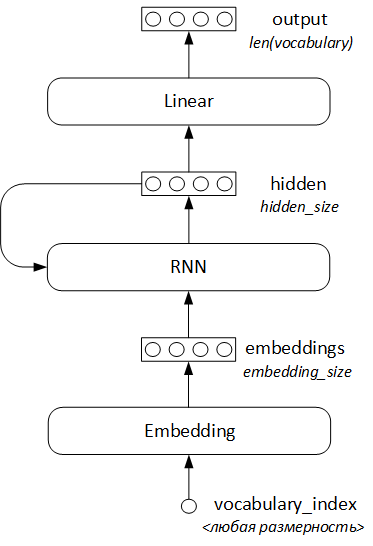

---
Функция, которая по входной строке возвращает список индексов из словаря `vocabulary`:

In [9]:
def char_to_tensor(string, vocabulary):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = vocabulary.index(string[c])
    return tensor

indices = char_to_tensor('онегин', vocabulary)
print(indices)

tensor([64, 63, 55, 53, 58, 63])


Напишем также функцию для обратного преобразования из списка индексов в строку:

In [10]:
def tensor_to_char(tensor, vocabulary):
    s = ''
    for t in tensor:
        s += vocabulary[int(t)]
    return s

print(tensor_to_char(indices, vocabulary))

онегин


---
Напишем функцию для генерации пары (входная последовательность, выходная последовательность).  
В качестве входной (обучающей) последовательности выступает случайная строка без последнего символа;  
выходная последовательность – та же строка без первого символа.  
Таким образом, каждому элементу входной последовательности (символу) соответствует элемент выходной последовательности (символ), который является следующим символом в строке.  
Выходная последовательность является целевой переменной, именно её сеть будет пытаться предсказать.  
Размер каждой последовательности – `seq_len`.

In [11]:
def random_training_set(data, seq_len, vocabulary):
    sequence = random_sequence(data, seq_len)
    input = char_to_tensor(sequence[:-1], vocabulary)
    target = char_to_tensor(sequence[1:], vocabulary)
    return input, target

In [12]:
input, target = random_training_set(data, seq_len, vocabulary)

print(f'********** input ({len(input)})**********\n\n{input.data}')
print(f'\n********** target ({len(target)}) **********\n{target.data}')

********** input (200)**********

tensor([ 0, 58,  1, 50, 61, 78, 62, 50, 63, 50, 71, 58,  7,  1, 58,  1, 56, 69,
        66, 63, 50, 61, 77,  7,  0, 53, 54, 55,  1, 65, 64, 69, 73, 55, 63, 78,
        81,  1, 63, 50, 62,  1, 68, 52, 55, 66, 54, 81, 68,  7,  0, 53, 54, 55,
         1, 63, 77, 63, 73, 55,  1, 68, 50, 60,  1, 62, 55, 63, 81,  1, 51, 66,
        50, 63, 81, 68,  7,  0, 50,  1, 53, 54, 55,  1, 68, 50, 60, 58, 55,  1,
        62, 50, 54, 66, 58, 53, 50, 61, 77,  0, 67, 55, 51, 55,  1, 52, 67, 68,
        66, 55, 73, 50, 61,  1, 81,  1, 58, 63, 64, 53, 54, 50, 20,  0, 55,  1,
        40, 27, 34, 37, 39, 27,  1, 24, 27, 35, 27,  7,  1, 53, 64, 67, 65, 64,
        54, 50,  9,  0,  0, 45, 45, 45, 43, 31,  0,  0, 58,  1, 73, 68, 64,  1,
        56, 22,  1, 53, 61, 50, 57, 50,  1, 55, 53, 64,  1, 73, 58, 68, 50, 61,
        58,  7,  0, 63, 64,  1, 62, 77, 67, 61, 58,  1, 51, 77, 61, 58,  1, 54,
        50, 61])

********** target (200) **********
tensor([58,  1, 50, 61, 78, 62, 5

Преобразуем полученные тензоры в строки:

In [13]:
print(f'********** input **********\n\n{tensor_to_char(input, vocabulary)}')
print(f'\n********** target **********\n\n{tensor_to_char(target, vocabulary)}')

********** input **********


и альманахи, и журналы,
где поученья нам твердят,
где нынче так меня бранят,
а где такие мадригалы
себе встречал я иногда:
е sempre bene, господа.

xxxvi

и что ж? глаза его читали,
но мысли были дал

********** target **********

и альманахи, и журналы,
где поученья нам твердят,
где нынче так меня бранят,
а где такие мадригалы
себе встречал я иногда:
е sempre bene, господа.

xxxvi

и что ж? глаза его читали,
но мысли были дале


---
RNN требует на вход трехмерный тензор размерностью: `(seq_len, batch_size, input_size)`:
\
\
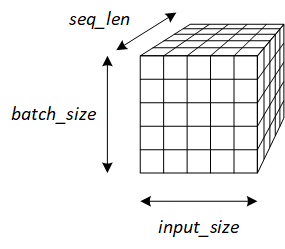


Таким образом, последовательности символов будут располагаться вдоль размерности `seq_len`.

Этот трехмерный тензор подается на вход RNN по мини-батчам:
\
\
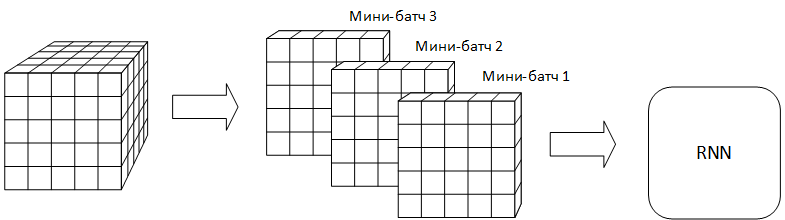

Каждый мини-батч обрабатывается в RNN одновременно; при этом формируется столько же скрытых состояний, сколько векторов в мини-батче. Эти скрытые состояния также являются выходами RNN: на каждый вектор мини-батча – свой выходной вектор (он же скрытое состояние).

В нашем примере:
- `input_size = 1` – на вход подается только индекс текущего символа в словаре, который в слое `Embedding` преобразуется в вектор размерности `embedding_size`;
- `batch_size = batch_size_train` – размер мини-батча;
- `seq_len = 200` – длина последовательности символов на одном шаге:
\
\
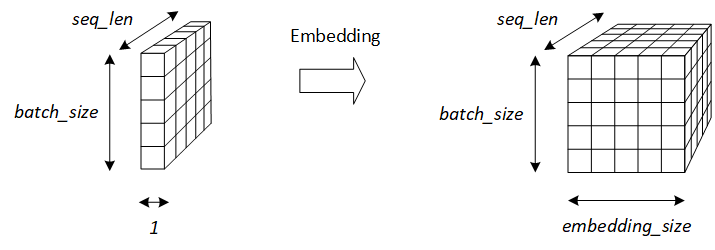

---
Зададим функцию обучения для одной эпохи – это процедура обработки в RNN всех мини-батчей, входящих в последовательность размером `seq_len`. Каждый мини-батч включает всего один индекс символа в словаре.  

Инициализация (обнуление) скрытого состояния происходит в начале каждого шага. Существует две стратегии инициализации скрытого состояния:
1. Если обрабатываются продолжительные непрерывные входные данные (например, "Война и мир"), разбитые на последовательности, и последовательность на текущем шаге является продолжением последовательности на предыдущем шаге, то скрытые состояния можно передавать с предыдущей эпохи (после обработки всей последовательности).
1. Если датасет состоит из отдельных последовательностей, не связанных между собой (например, твитов), то скрытое состояние желательно обнулять перед каждой эпохой.  

В нашем примере последовательности для каждой эпохи формируются независимо друг от друга, поэтому скрытые состояния обнуляются.

In [14]:
def train(input, target, batch_size):
    '''
    input - тензор размерности (seq_len, batch_size). Тензор содержит индексы символов.
    target - истинная последовательность индексов следующих символов (целевая переменная); размерность (seq_len, batch_size)
    '''
    
    # Инициализируем скрытое состояние
    hidden = rnn.init_hidden(batch_size=batch_size)
    
    rnn.zero_grad()
    loss = 0
    
    outputs, hidden = rnn(input, hidden)
    
    # Преобразуем размерности для вычисления функции потерь
    outputs = outputs.view(seq_len * batch_size, -1)
    target = target.view(seq_len * batch_size)
    
    loss = criterion(outputs, target)
    
    loss.backward()
    rnn_optimizer.step()

    return loss.data / len(input)

---
Операция `view` в PyTorch создает новый тензор как "представление" существущего тензора: сами данные никуда не копируются, но размерность данных меняется. Таким образом, экономятся память и время.

In [15]:
# Пример
t = torch.rand(2, 2)
print(f'Исходный тензор:\n{t}')

b = t.view(1, -1)
print(f'\nТензор-представление (view):\n{b}')

# Данные в обоих тензорах разделяются
print(f'\nДанные совпадают? - {t.untyped_storage().data_ptr() == b.untyped_storage().data_ptr()}')

# Изменение тензора-представления изменяет базовый тензор
b[0][1] = 1
print(f'\nИсходный тензор:\n{t}')

# Растягиваем двумерный тензор в одномерный
b = b.view(-1)
print(f'\nОдномерный тензор:\n{b}')

Исходный тензор:
tensor([[0.8155, 0.7932],
        [0.2783, 0.4820]])

Тензор-представление (view):
tensor([[0.8155, 0.7932, 0.2783, 0.4820]])

Данные совпадают? - True

Исходный тензор:
tensor([[0.8155, 1.0000],
        [0.2783, 0.4820]])

Одномерный тензор:
tensor([0.8155, 1.0000, 0.2783, 0.4820])


---
Напишем функцию, генерирующую текст длины `predict_len` с началом (префиксной строкой) `prefix`.  
Результирующая строка будет иметь вид: `prefix` + сгенерированная строка.

In [16]:
def evaluate(model, vocabulary, batch_size, prefix='а', predict_len=100):
    
    # Инициализируем скрытое состояние
    hidden = model.init_hidden(batch_size)
    
    # Преобразуем префиксную строку в тензор индексов
    prefix_input = char_to_tensor(prefix, vocabulary)
    
    # В переменной predicted будет храниться порождаемая строка (результат работы всей функции).
    # Записываем в неё сначала префиксную строку
    predicted = prefix

    # Запускаем модель на префиксной строке - формируем скрытое состояние для дальнейшей генерации
    for p in range(len(prefix) - 1):
        input = prefix_input[p]
        input = input.view(-1, 1)
        outputs, hidden = model(input, hidden)
    
    # В качестве первого символа для генерации (предсказания следующего символа) выступает последний символ префиксной строки
    input = prefix_input[-1]
    input = input.reshape(-1, 1)

    # Генерируем predict_len символов
    for p in range(predict_len):
        
        # Запускаем модель с текущим входным символом и текущим скрытым состоянием
        output, hidden = model(input, hidden)
        
        # В output возвращаются вероятности всех символов из словаря.
        # Выбираем из этого распределения символ (сэмплируем)
        output_dist = output.data.view(-1)
        output_dist = output_dist.exp()
        top_index = torch.multinomial(output_dist, 1)[0]
        
        # Добавляем предсказанный символ в результирующую строку
        predicted_char = vocabulary[top_index]
        predicted += predicted_char
        
        # Используем предсказанный символ как следующий вход
        input = char_to_tensor(predicted_char, vocabulary)
        input = input.reshape(-1, 1)

    return predicted

Вспомогательная функция для вывода времени:

In [17]:
def time_since(since):
    seconds = time.time() - since
    minutes = math.floor(seconds / 60)
    seconds -= minutes * 60
    return f'{minutes} min {seconds:.0f} sec'

---
Основная процедура обучения и генерации примеров текста в процессе обучения.  
Генерация текстов в ходе обучения необходима только для иллюстрации изменений возможностей модели по мере обучения.

In [18]:
# Создаем модель
rnn = RNN(
    input_size=len(vocabulary),
    embedding_size=embedding_size,
    hidden_size=hidden_size,
    output_size=len(vocabulary),
    num_layers=num_layers
)

rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()

prefix = 'а'         # Префиксная строка для генерации в процессе обучения. 

all_losses = []      # Список значений функции потерь в процессе обучения (для графика)
loss_avg = 0         # Усредненное по `plot_every` эпохам значение функции потерь для графика

for epoch in range(1, n_epochs + 1):
    
    # Генерируем первую последовательность
    input, target = random_training_set(data, seq_len, vocabulary)
    input = input.view(-1, 1)
    target = target.view(-1, 1)
    
    # Добавляем к первой последовательности другие в зависимости от количества мини-батчей
    for b in range(batch_size_train-1):
        sequence, target_seq = random_training_set(data, seq_len, vocabulary)
        sequence = sequence.view(-1, 1)
        target_seq = target_seq.view(-1, 1)
        input = torch.cat((input, sequence), dim=1)
        target = torch.cat((target, target_seq), dim=1)
    
    # Запускаем эпоху обучения
    loss = train(input, target, batch_size_train)
    loss_avg += loss

    # Осуществляем генерацию текста для текущей модели каждые `print_every` эпох
    if epoch % print_every == 0:
        
        print(f'[time = {time_since(start)}, epochs = {epoch} ({epoch / n_epochs * 100}%), loss = {loss:.4f}]')
        
        predicted_text = evaluate(
            model=rnn,
            vocabulary=vocabulary,
            batch_size=batch_size_test,
            prefix=prefix,
            predict_len=predict_len
        )
        print(predicted_text)
        print()

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

[time = 0 min 2 sec, epochs = 100 (10.0%), loss = 0.0133]
ам,
преитовецй бен талан
е бегодавыйу
сслюбеле па дожал яень седетни;
бонат села муг..
черва.
согруя 

[time = 0 min 3 sec, epochs = 200 (20.0%), loss = 0.0129]
авно с посние примоей,
онагко рам.
вюток, мее с тодиму
воскисноеальем бедной! к ничась был, нак сетви

[time = 0 min 5 sec, epochs = 300 (30.0%), loss = 0.0128]
ах вдей! вдрестилань,
чее лагое путе, зеегряшечук него всляний пирет,
все бездруча.
нуж двере в любме

[time = 0 min 6 sec, epochs = 400 (40.0%), loss = 0.0118]
а?
и заковино лечем поб мал еескиа в божн кн;
опумливи! щедт кошностьет
он,
моед
и лесчитей
с левес;


[time = 0 min 8 sec, epochs = 500 (50.0%), loss = 0.0023]
ав:
к;
облондей вдосвябеду гордей;
как кто пепод {36}
явык.
- молосама орда залокя трабеде боловых;
у

[time = 0 min 9 sec, epochs = 600 (60.0%), loss = 0.0113]
азаждят ле вал славы,
блатять, я внив богыри собля больбою посал той,
богесо попозда увосты путьпеня,

[time = 0 min 11 sec, epochs = 700

---
Рисуем график потерь:

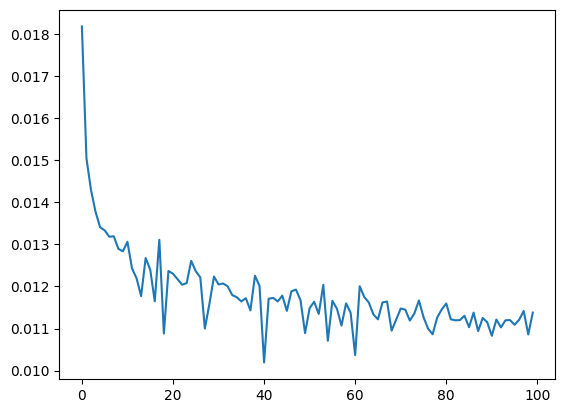

In [19]:
plt.figure()
plt.plot(all_losses)

После обучения можно подставить любое начало и сеть его продолжит:

In [20]:
beginning = 'мой дядя'

predict = evaluate(
    model=rnn,
    vocabulary=vocabulary,
    batch_size=batch_size_test,
    prefix=beginning,
    predict_len=predict_len
)

print(predict)

мой дядя знежму,
нись в зоб отур ней, стую недсвите
спиже, идмой моли иъковилит,
о коскучилочных томрежене м


---
#### Задание 1.
Перенесите модель и данные на GPU.

In [21]:
# --- Начало модификаций для Задания 1 ---
# Определяем устройство (GPU, если доступно, иначе CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используем устройство: {device}")
# --- Конец модификаций для Задания 1 ---

# Создаем модель
rnn = RNN(
    input_size=len(vocabulary),
    embedding_size=embedding_size,
    hidden_size=hidden_size,
    output_size=len(vocabulary),
    num_layers=num_layers
)

# --- Начало модификаций для Задания 1 ---
# Перемещаем модель на выбранное устройство
rnn.to(device)

# ВАЖНО: Для корректной работы на GPU, необходимо также модифицировать:
# 1. Метод `init_hidden` в классе `RNN` (Ячейка 16).
#    Он должен создавать тензор скрытого состояния на том же устройстве, что и модель.
#    Пример изменения в `init_hidden`:
#    # device = next(self.parameters()).device # Получаем устройство модели
#    # return torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)
#
# 2. Функцию `evaluate` (Ячейка 32).
#    Все тензоры (например, prefix_input, input создаваемый из predicted_char, и hidden)
#    должны создаваться или перемещаться на `device`.
#    Пример для prefix_input:
#    # prefix_input = char_to_tensor(prefix, vocabulary).to(device)
#    Пример для hidden (если init_hidden не делает это автоматически):
#    # hidden = model.init_hidden(batch_size).to(device)
#    Пример для input, создаваемого в цикле генерации:
#    # input = char_to_tensor(predicted_char, vocabulary).to(device)
# --- Конец модификаций для Задания 1 ---

rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() # Эта функция потерь будет работать с тензорами на GPU, если ее входы на GPU

start = time.time()

prefix = 'а'         # Префиксная строка для генерации в процессе обучения.

all_losses = []      # Список значений функции потерь в процессе обучения (для графика)
loss_avg = 0         # Усредненное по `plot_every` эпохам значение функции потерь для графика

for epoch in range(1, n_epochs + 1):

    # Генерируем первую последовательность
    # Используем более явные имена переменных input_tensor, target_tensor
    input_tensor_cpu, target_tensor_cpu = random_training_set(data, seq_len, vocabulary)

    # --- Начало модификаций для Задания 1 ---
    # Перемещаем тензоры на выбранное устройство
    input_batch = input_tensor_cpu.view(-1, 1).to(device)
    target_batch = target_tensor_cpu.view(-1, 1).to(device)
    # --- Конец модификаций для Задания 1 ---

    # Добавляем к первой последовательности другие в зависимости от количества мини-батчей
    # Этот цикл не будет выполняться, т.к. batch_size_train = 1
    # Если batch_size_train > 1, то sequence_cpu и target_seq_cpu также нужно будет перемещать на device
    for b in range(batch_size_train-1):
        sequence_cpu, target_seq_cpu = random_training_set(data, seq_len, vocabulary)
        # --- Начало модификаций для Задания 1 ---
        sequence_gpu = sequence_cpu.view(-1, 1).to(device) # Перемещаем на устройство
        target_seq_gpu = target_seq_cpu.view(-1, 1).to(device) # Перемещаем на устройство
        input_batch = torch.cat((input_batch, sequence_gpu), dim=1)
        target_batch = torch.cat((target_batch, target_seq_gpu), dim=1)
        # --- Конец модификаций для Задания 1 ---

    # Запускаем эпоху обучения
    # Функция train также должна быть готова к работе с тензорами на GPU.
    # В частности, rnn.init_hidden() внутри train должна возвращать тензор на правильном устройстве.
    # Если вы модифицировали init_hidden в классе RNN, то train должна работать корректно.
    loss = train(input_batch, target_batch, batch_size_train)
    loss_avg += loss

    # Осуществляем генерацию текста для текущей модели каждые `print_every` эпох
    if epoch % print_every == 0:

        print(f'[time = {time_since(start)}, epochs = {epoch} ({epoch / n_epochs * 100}%), loss = {loss:.4f}]')

        # Функция evaluate должна быть готова к работе с моделью и тензорами на GPU.
        # Если вы модифицировали evaluate, как указано в комментариях выше, она будет работать на GPU.
        predicted_text = evaluate(
            model=rnn, # rnn уже на device
            vocabulary=vocabulary,
            batch_size=batch_size_test, # batch_size_test = 1
            prefix=prefix,
            predict_len=predict_len
        )
        print(predicted_text)
        print()

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0


Используем устройство: cpu
[time = 0 min 2 sec, epochs = 100 (10.0%), loss = 0.0121]
а, докюж, тобоблетьмя музит олодою н естовотог лик ни жетаре подрахерца чидим года ватьань тежилнор у

[time = 0 min 3 sec, epochs = 200 (20.0%), loss = 0.0119]
альц;
и бобной ссе не брим прибый я дузовогнечкать меб мугчу, влова
застрасон, сноврою при"ротий,
на


[time = 0 min 5 sec, epochs = 300 (30.0%), loss = 0.0126]
азом сейшя
- нроварфов скае!. я лесь не анатьа, выл гнабит!
та вшугуюн? казовиден, лет,
баркий душко,

[time = 0 min 8 sec, epochs = 400 (40.0%), loss = 0.0122]
абний, колялат т однеге
вналиннай былны столит забодний,
ти ной
норешь. - разечно вежчан.

xxv

и моч

[time = 0 min 10 sec, epochs = 500 (50.0%), loss = 0.0109]
асплной, торить он гелечены чкой,
мон; нашенялись в рас прежсил;
токорет
леленежилово всесхой: итпреб

[time = 0 min 11 sec, epochs = 600 (60.0%), loss = 0.0110]
ать одне всевленний подред рослерже
на книть?".
он лятела
и лоднято сперже
всепы ей гротельнанчый в с

[time

#### Задание 2.
Запустите обучение модели с разным количеством эпох и размером мини-батча. Один или несколько результатов генерации в конце каждого эксперимента вместе с временем запуска и параметрами запишите в отдельный файл.  
Проведите не менее 10 экспериментов.  
Сделайте выводы об эффективности разных вариантов модели.

Используем устройство: cpu

--- Запуск эксперимента: Exp1_E500_B1 ---
Параметры: Эпохи=500, Размер батча (обуч.)=1, LR=0.005, Скрытый слой=100, Слои RNN=1
[Эксперимент: Exp1_E500_B1, Время: 0 min 2 sec, Эпоха: 100 (20.0%), Потеря: 0.0127]
[Эксперимент: Exp1_E500_B1, Время: 0 min 3 sec, Эпоха: 200 (40.0%), Потеря: 0.0124]
[Эксперимент: Exp1_E500_B1, Время: 0 min 5 sec, Эпоха: 300 (60.0%), Потеря: 0.0119]
[Эксперимент: Exp1_E500_B1, Время: 0 min 8 sec, Эпоха: 400 (80.0%), Потеря: 0.0118]
[Эксперимент: Exp1_E500_B1, Время: 0 min 9 sec, Эпоха: 500 (100.0%), Потеря: 0.0117]
--- Эксперимент Exp1_E500_B1 завершен ---
Время обучения: 0 min 9 sec
Финальная средняя потеря: 0.0117
Сгенерированный текст (начало 'мой дядя', длина 200):
мой дядят нагды дудов безду:
кознет
замдовал;.
на нашит переы сеитовецы без тала:
гот годены, он прочук по дожал яень сез тни;
бо поэтель!

э..
вервы.
онь упов,
ил хоинка в умоей,
белькой ко. вю блары, чуштва



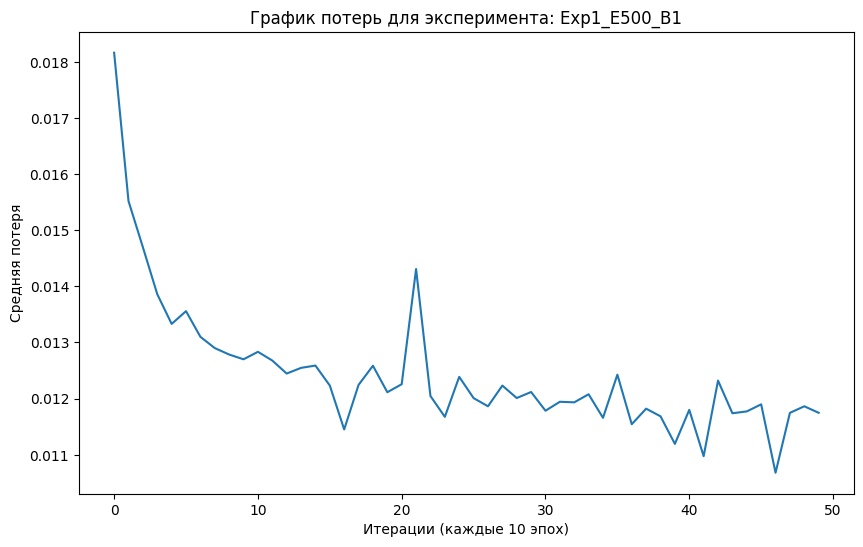


--- Запуск эксперимента: Exp2_E1000_B1 ---
Параметры: Эпохи=1000, Размер батча (обуч.)=1, LR=0.005, Скрытый слой=100, Слои RNN=1
[Эксперимент: Exp2_E1000_B1, Время: 0 min 2 sec, Эпоха: 100 (10.0%), Потеря: 0.0127]
[Эксперимент: Exp2_E1000_B1, Время: 0 min 3 sec, Эпоха: 200 (20.0%), Потеря: 0.0124]
[Эксперимент: Exp2_E1000_B1, Время: 0 min 6 sec, Эпоха: 300 (30.0%), Потеря: 0.0119]
[Эксперимент: Exp2_E1000_B1, Время: 0 min 8 sec, Эпоха: 400 (40.0%), Потеря: 0.0118]
[Эксперимент: Exp2_E1000_B1, Время: 0 min 9 sec, Эпоха: 500 (50.0%), Потеря: 0.0117]
[Эксперимент: Exp2_E1000_B1, Время: 0 min 11 sec, Эпоха: 600 (60.0%), Потеря: 0.0123]
[Эксперимент: Exp2_E1000_B1, Время: 0 min 12 sec, Эпоха: 700 (70.0%), Потеря: 0.0117]
[Эксперимент: Exp2_E1000_B1, Время: 0 min 14 sec, Эпоха: 800 (80.0%), Потеря: 0.0122]
[Эксперимент: Exp2_E1000_B1, Время: 0 min 15 sec, Эпоха: 900 (90.0%), Потеря: 0.0110]
[Эксперимент: Exp2_E1000_B1, Время: 0 min 17 sec, Эпоха: 1000 (100.0%), Потеря: 0.0105]
--- Экспериме

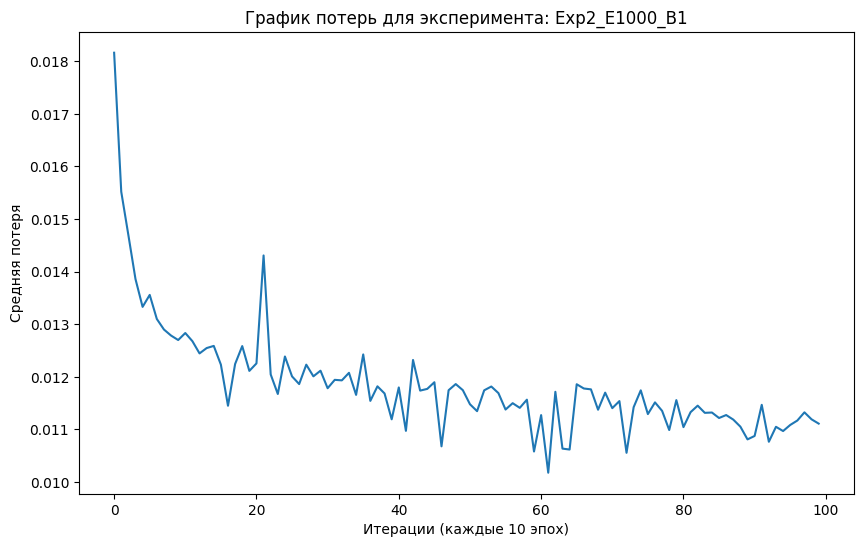


--- Запуск эксперимента: Exp3_E1500_B1 ---
Параметры: Эпохи=1500, Размер батча (обуч.)=1, LR=0.005, Скрытый слой=100, Слои RNN=1
[Эксперимент: Exp3_E1500_B1, Время: 0 min 2 sec, Эпоха: 100 (6.7%), Потеря: 0.0127]
[Эксперимент: Exp3_E1500_B1, Время: 0 min 3 sec, Эпоха: 200 (13.3%), Потеря: 0.0124]
[Эксперимент: Exp3_E1500_B1, Время: 0 min 5 sec, Эпоха: 300 (20.0%), Потеря: 0.0119]
[Эксперимент: Exp3_E1500_B1, Время: 0 min 6 sec, Эпоха: 400 (26.7%), Потеря: 0.0118]
[Эксперимент: Exp3_E1500_B1, Время: 0 min 8 sec, Эпоха: 500 (33.3%), Потеря: 0.0117]
[Эксперимент: Exp3_E1500_B1, Время: 0 min 9 sec, Эпоха: 600 (40.0%), Потеря: 0.0123]
[Эксперимент: Exp3_E1500_B1, Время: 0 min 11 sec, Эпоха: 700 (46.7%), Потеря: 0.0117]
[Эксперимент: Exp3_E1500_B1, Время: 0 min 14 sec, Эпоха: 800 (53.3%), Потеря: 0.0122]
[Эксперимент: Exp3_E1500_B1, Время: 0 min 16 sec, Эпоха: 900 (60.0%), Потеря: 0.0110]
[Эксперимент: Exp3_E1500_B1, Время: 0 min 17 sec, Эпоха: 1000 (66.7%), Потеря: 0.0105]
[Эксперимент: Ex

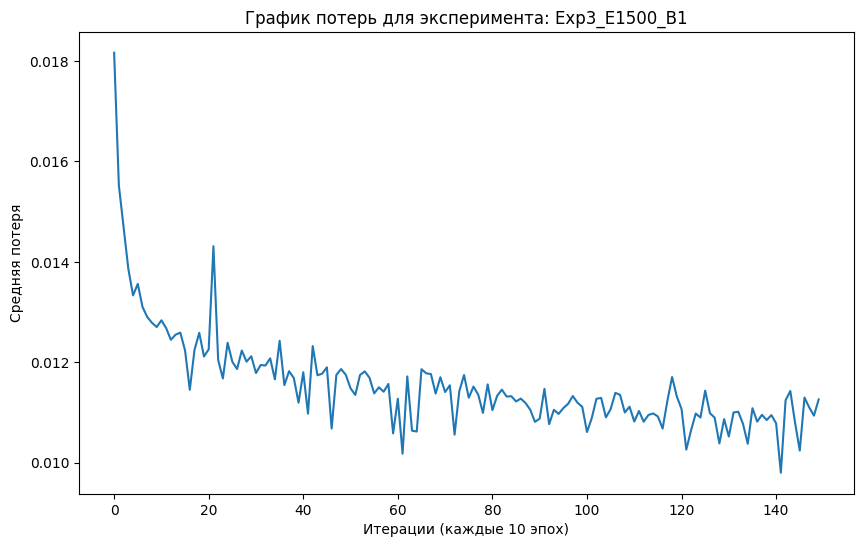


--- Запуск эксперимента: Exp4_E500_B4 ---
Параметры: Эпохи=500, Размер батча (обуч.)=4, LR=0.005, Скрытый слой=100, Слои RNN=1
[Эксперимент: Exp4_E500_B4, Время: 0 min 2 sec, Эпоха: 100 (20.0%), Потеря: 0.0120]
[Эксперимент: Exp4_E500_B4, Время: 0 min 5 sec, Эпоха: 200 (40.0%), Потеря: 0.0118]
[Эксперимент: Exp4_E500_B4, Время: 0 min 7 sec, Эпоха: 300 (60.0%), Потеря: 0.0113]
[Эксперимент: Exp4_E500_B4, Время: 0 min 10 sec, Эпоха: 400 (80.0%), Потеря: 0.0107]
[Эксперимент: Exp4_E500_B4, Время: 0 min 12 sec, Эпоха: 500 (100.0%), Потеря: 0.0109]
--- Эксперимент Exp4_E500_B4 завершен ---
Время обучения: 0 min 12 sec
Финальная средняя потеря: 0.0107
Сгенерированный текст (начало 'мой дядя', длина 200):
мой дядят
на недувно жду душакой
в сердце выша мули в так нашит и светы екно в уницу гладавый он причук по доло, яень сем темалось ты, до жим.

xxti

прикрыл в кик хо на же сегой,
онадки рам.

кобкары, чуштва



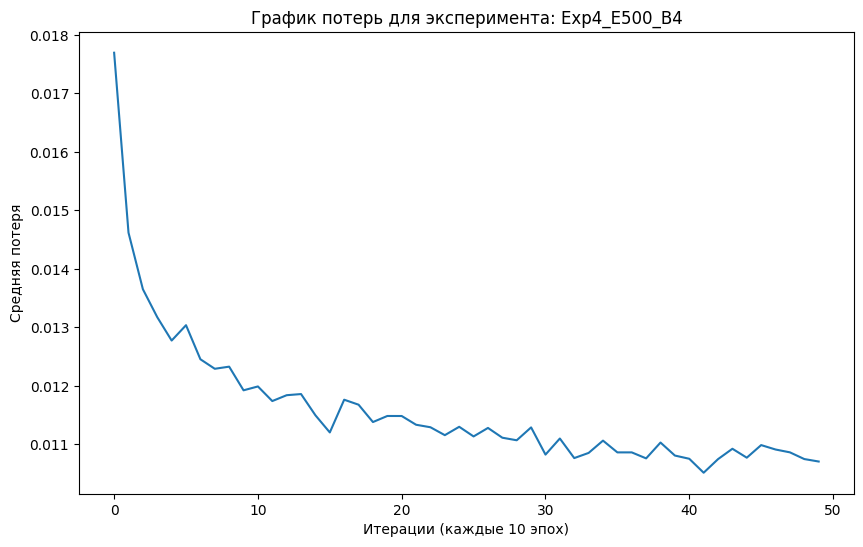


--- Запуск эксперимента: Exp5_E1000_B4 ---
Параметры: Эпохи=1000, Размер батча (обуч.)=4, LR=0.005, Скрытый слой=100, Слои RNN=1
[Эксперимент: Exp5_E1000_B4, Время: 0 min 2 sec, Эпоха: 100 (10.0%), Потеря: 0.0120]
[Эксперимент: Exp5_E1000_B4, Время: 0 min 5 sec, Эпоха: 200 (20.0%), Потеря: 0.0118]
[Эксперимент: Exp5_E1000_B4, Время: 0 min 7 sec, Эпоха: 300 (30.0%), Потеря: 0.0113]
[Эксперимент: Exp5_E1000_B4, Время: 0 min 10 sec, Эпоха: 400 (40.0%), Потеря: 0.0107]
[Эксперимент: Exp5_E1000_B4, Время: 0 min 12 sec, Эпоха: 500 (50.0%), Потеря: 0.0109]
[Эксперимент: Exp5_E1000_B4, Время: 0 min 15 sec, Эпоха: 600 (60.0%), Потеря: 0.0105]
[Эксперимент: Exp5_E1000_B4, Время: 0 min 19 sec, Эпоха: 700 (70.0%), Потеря: 0.0106]
[Эксперимент: Exp5_E1000_B4, Время: 0 min 21 sec, Эпоха: 800 (80.0%), Потеря: 0.0102]
[Эксперимент: Exp5_E1000_B4, Время: 0 min 24 sec, Эпоха: 900 (90.0%), Потеря: 0.0102]
[Эксперимент: Exp5_E1000_B4, Время: 0 min 26 sec, Эпоха: 1000 (100.0%), Потеря: 0.0103]
--- Экспери

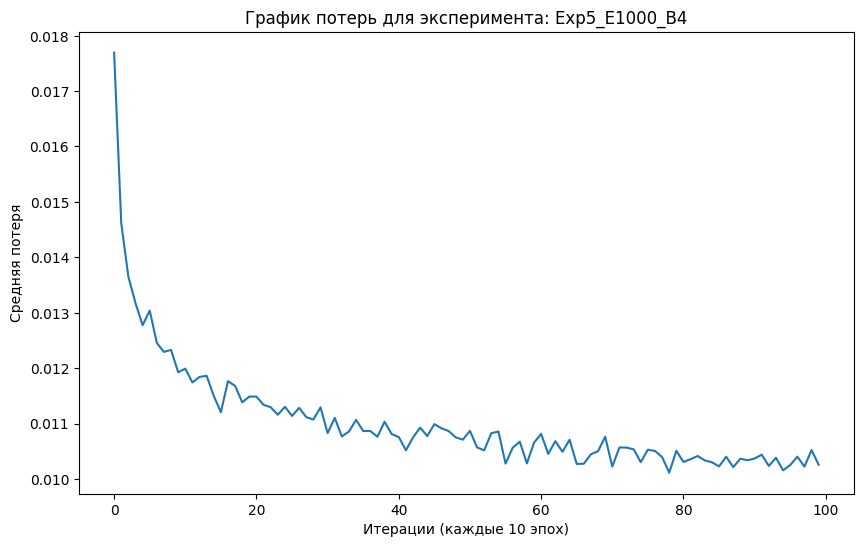


--- Запуск эксперимента: Exp6_E1500_B4 ---
Параметры: Эпохи=1500, Размер батча (обуч.)=4, LR=0.005, Скрытый слой=100, Слои RNN=1
[Эксперимент: Exp6_E1500_B4, Время: 0 min 2 sec, Эпоха: 100 (6.7%), Потеря: 0.0120]
[Эксперимент: Exp6_E1500_B4, Время: 0 min 5 sec, Эпоха: 200 (13.3%), Потеря: 0.0118]
[Эксперимент: Exp6_E1500_B4, Время: 0 min 7 sec, Эпоха: 300 (20.0%), Потеря: 0.0113]
[Эксперимент: Exp6_E1500_B4, Время: 0 min 10 sec, Эпоха: 400 (26.7%), Потеря: 0.0107]
[Эксперимент: Exp6_E1500_B4, Время: 0 min 12 sec, Эпоха: 500 (33.3%), Потеря: 0.0109]
[Эксперимент: Exp6_E1500_B4, Время: 0 min 14 sec, Эпоха: 600 (40.0%), Потеря: 0.0105]
[Эксперимент: Exp6_E1500_B4, Время: 0 min 17 sec, Эпоха: 700 (46.7%), Потеря: 0.0106]
[Эксперимент: Exp6_E1500_B4, Время: 0 min 19 sec, Эпоха: 800 (53.3%), Потеря: 0.0102]
[Эксперимент: Exp6_E1500_B4, Время: 0 min 22 sec, Эпоха: 900 (60.0%), Потеря: 0.0102]
[Эксперимент: Exp6_E1500_B4, Время: 0 min 24 sec, Эпоха: 1000 (66.7%), Потеря: 0.0103]
[Эксперимент:

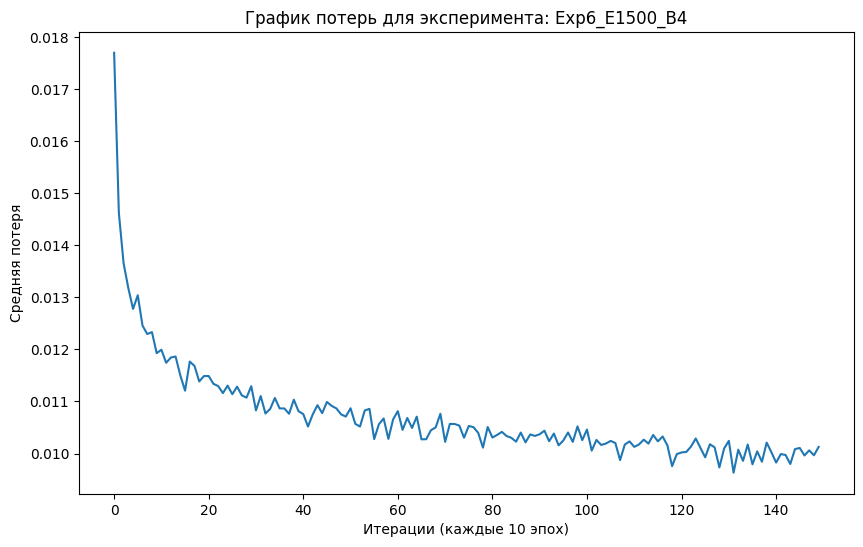


--- Запуск эксперимента: Exp7_E500_B8 ---
Параметры: Эпохи=500, Размер батча (обуч.)=8, LR=0.005, Скрытый слой=100, Слои RNN=1
[Эксперимент: Exp7_E500_B8, Время: 0 min 3 sec, Эпоха: 100 (20.0%), Потеря: 0.0121]
[Эксперимент: Exp7_E500_B8, Время: 0 min 9 sec, Эпоха: 200 (40.0%), Потеря: 0.0109]
[Эксперимент: Exp7_E500_B8, Время: 0 min 12 sec, Эпоха: 300 (60.0%), Потеря: 0.0107]
[Эксперимент: Exp7_E500_B8, Время: 0 min 17 sec, Эпоха: 400 (80.0%), Потеря: 0.0102]
[Эксперимент: Exp7_E500_B8, Время: 0 min 22 sec, Эпоха: 500 (100.0%), Потеря: 0.0102]
--- Эксперимент Exp7_E500_B8 завершен ---
Время обучения: 0 min 22 sec
Финальная средняя потеря: 0.0105
Сгенерированный текст (начало 'мой дядя', длина 200):
мой дядясь пеншиду чужбы стобкой
все, кровал;
она что так масся исных тое в таня:
готогодиный онегин укрогахожал яень сердце.
косет;
пелоды,
прочерва.
он был волит холчка в сегой,
она кограм.
все, признал ты,



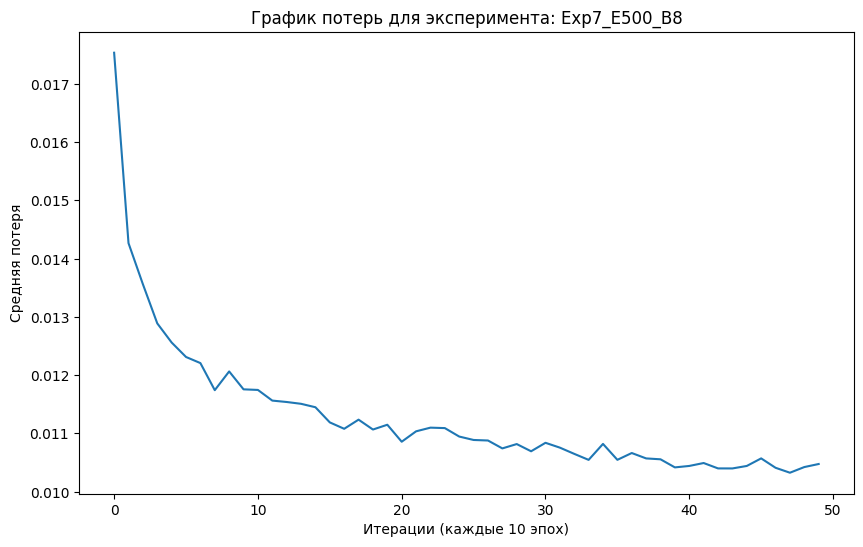


--- Запуск эксперимента: Exp8_E1000_B8 ---
Параметры: Эпохи=1000, Размер батча (обуч.)=8, LR=0.005, Скрытый слой=100, Слои RNN=1
[Эксперимент: Exp8_E1000_B8, Время: 0 min 4 sec, Эпоха: 100 (10.0%), Потеря: 0.0121]
[Эксперимент: Exp8_E1000_B8, Время: 0 min 9 sec, Эпоха: 200 (20.0%), Потеря: 0.0109]
[Эксперимент: Exp8_E1000_B8, Время: 0 min 14 sec, Эпоха: 300 (30.0%), Потеря: 0.0107]
[Эксперимент: Exp8_E1000_B8, Время: 0 min 18 sec, Эпоха: 400 (40.0%), Потеря: 0.0102]
[Эксперимент: Exp8_E1000_B8, Время: 0 min 21 sec, Эпоха: 500 (50.0%), Потеря: 0.0102]
[Эксперимент: Exp8_E1000_B8, Время: 0 min 26 sec, Эпоха: 600 (60.0%), Потеря: 0.0106]
[Эксперимент: Exp8_E1000_B8, Время: 0 min 30 sec, Эпоха: 700 (70.0%), Потеря: 0.0100]
[Эксперимент: Exp8_E1000_B8, Время: 0 min 33 sec, Эпоха: 800 (80.0%), Потеря: 0.0103]
[Эксперимент: Exp8_E1000_B8, Время: 0 min 39 sec, Эпоха: 900 (90.0%), Потеря: 0.0099]
[Эксперимент: Exp8_E1000_B8, Время: 0 min 44 sec, Эпоха: 1000 (100.0%), Потеря: 0.0100]
--- Экспер

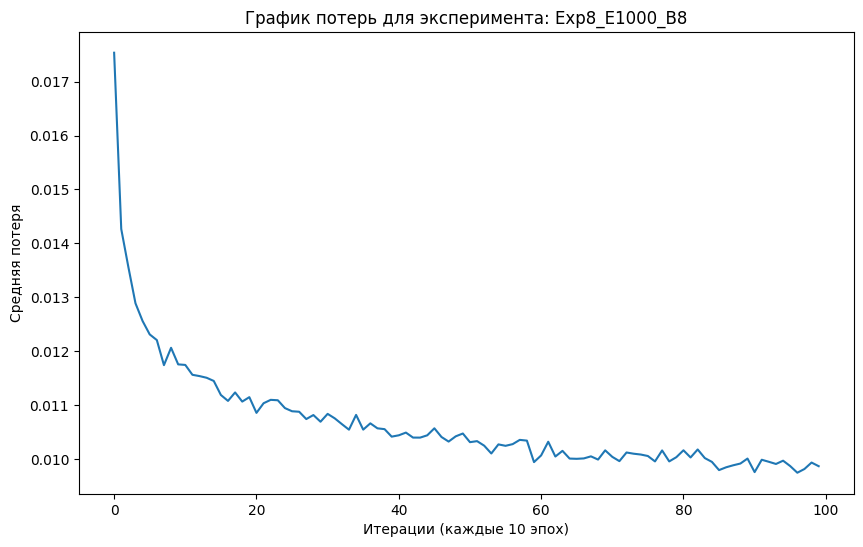


--- Запуск эксперимента: Exp9_E200_B16_Quick ---
Параметры: Эпохи=200, Размер батча (обуч.)=16, LR=0.005, Скрытый слой=100, Слои RNN=1
[Эксперимент: Exp9_E200_B16_Quick, Время: 0 min 7 sec, Эпоха: 100 (50.0%), Потеря: 0.0116]
[Эксперимент: Exp9_E200_B16_Quick, Время: 0 min 14 sec, Эпоха: 200 (100.0%), Потеря: 0.0110]
--- Эксперимент Exp9_E200_B16_Quick завершен ---
Время обучения: 0 min 14 sec
Финальная средняя потеря: 0.0109
Сгенерированный текст (начало 'мой дядя', длина 200):
мой дядясь {34)},
но жде стобкой,
трежудовяльном.
но мне чемы не советы ере тала:
где годере,
он простеть трозала... нагде нем боготы, лодым умовервый согруя волит хоинка в и гере!
еддка рамя вюд, не бечны ла



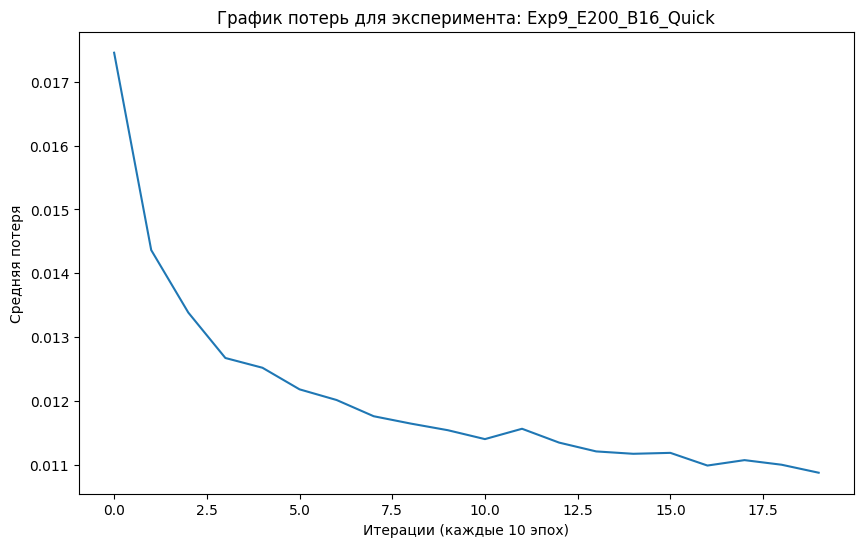


--- Запуск эксперимента: Exp10_E2000_B2 ---
Параметры: Эпохи=2000, Размер батча (обуч.)=2, LR=0.005, Скрытый слой=100, Слои RNN=1
[Эксперимент: Exp10_E2000_B2, Время: 0 min 2 sec, Эпоха: 100 (5.0%), Потеря: 0.0122]
[Эксперимент: Exp10_E2000_B2, Время: 0 min 4 sec, Эпоха: 200 (10.0%), Потеря: 0.0116]
[Эксперимент: Exp10_E2000_B2, Время: 0 min 6 sec, Эпоха: 300 (15.0%), Потеря: 0.0115]
[Эксперимент: Exp10_E2000_B2, Время: 0 min 8 sec, Эпоха: 400 (20.0%), Потеря: 0.0116]
[Эксперимент: Exp10_E2000_B2, Время: 0 min 10 sec, Эпоха: 500 (25.0%), Потеря: 0.0110]
[Эксперимент: Exp10_E2000_B2, Время: 0 min 12 sec, Эпоха: 600 (30.0%), Потеря: 0.0110]
[Эксперимент: Exp10_E2000_B2, Время: 0 min 14 sec, Эпоха: 700 (35.0%), Потеря: 0.0114]
[Эксперимент: Exp10_E2000_B2, Время: 0 min 16 sec, Эпоха: 800 (40.0%), Потеря: 0.0109]
[Эксперимент: Exp10_E2000_B2, Время: 0 min 18 sec, Эпоха: 900 (45.0%), Потеря: 0.0101]
[Эксперимент: Exp10_E2000_B2, Время: 0 min 20 sec, Эпоха: 1000 (50.0%), Потеря: 0.0112]
[Эк

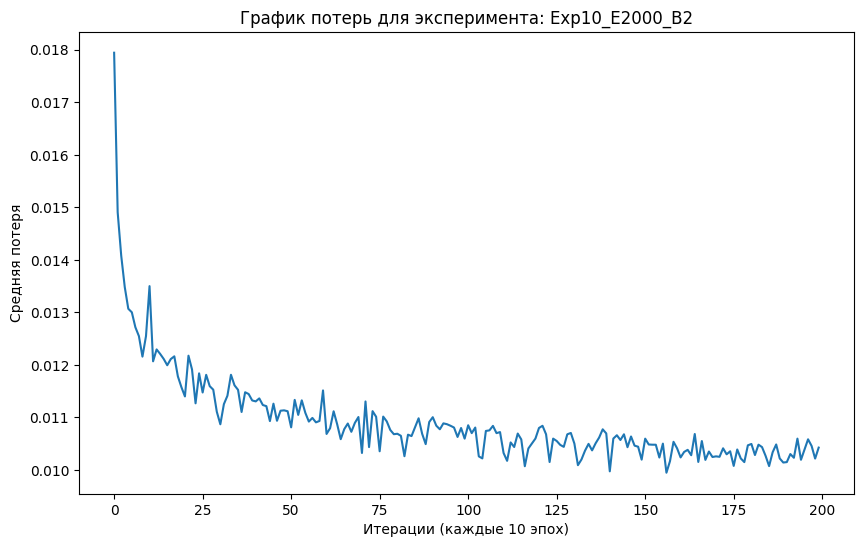


Все эксперименты завершены. Результаты сохранены в файле: experiment_results_task2.txt


In [22]:
# Определяем эксперименты
# Каждый словарь содержит параметры для одного эксперимента.
# Мы будем варьировать n_epochs и batch_size_train.
# Другие параметры, такие как lr, hidden_size, также можно варьировать.
experiments = [
    {'n_epochs': 500,  'batch_size_train': 1,  'lr': 0.005, 'hidden_size': 100, 'num_layers': 1, 'experiment_label': 'Exp1_E500_B1'},
    {'n_epochs': 1000, 'batch_size_train': 1,  'lr': 0.005, 'hidden_size': 100, 'num_layers': 1, 'experiment_label': 'Exp2_E1000_B1'},
    {'n_epochs': 1500, 'batch_size_train': 1,  'lr': 0.005, 'hidden_size': 100, 'num_layers': 1, 'experiment_label': 'Exp3_E1500_B1'},
    {'n_epochs': 500,  'batch_size_train': 4,  'lr': 0.005, 'hidden_size': 100, 'num_layers': 1, 'experiment_label': 'Exp4_E500_B4'},
    {'n_epochs': 1000, 'batch_size_train': 4,  'lr': 0.005, 'hidden_size': 100, 'num_layers': 1, 'experiment_label': 'Exp5_E1000_B4'},
    {'n_epochs': 1500, 'batch_size_train': 4,  'lr': 0.005, 'hidden_size': 100, 'num_layers': 1, 'experiment_label': 'Exp6_E1500_B4'},
    {'n_epochs': 500,  'batch_size_train': 8,  'lr': 0.005, 'hidden_size': 100, 'num_layers': 1, 'experiment_label': 'Exp7_E500_B8'},
    {'n_epochs': 1000, 'batch_size_train': 8,  'lr': 0.005, 'hidden_size': 100, 'num_layers': 1, 'experiment_label': 'Exp8_E1000_B8'},
    {'n_epochs': 200,  'batch_size_train': 16, 'lr': 0.005, 'hidden_size': 100, 'num_layers': 1, 'experiment_label': 'Exp9_E200_B16_Quick'},
    {'n_epochs': 2000, 'batch_size_train': 2,  'lr': 0.005, 'hidden_size': 100, 'num_layers': 1, 'experiment_label': 'Exp10_E2000_B2'},
]

# Файл для логирования результатов
results_log_file = "experiment_results_task2.txt"
# Открываем файл в режиме "w" (write), чтобы перезаписать его при новом запуске всех экспериментов.
# Если хотите добавлять результаты к существующему файлу, используйте режим "a" (append).
with open(results_log_file, "w", encoding="utf-8") as f:
    f.write("--- Журнал экспериментов (Задание 2) ---\n\n")

# Настройка устройства (GPU, если доступно)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используем устройство: {device}")

# Предполагается, что 'data' и 'vocabulary' загружены в предыдущих ячейках
# data = data.lower() # из ячейки 12
# vocabulary = sorted(list(set(data))) # из ячейки 12

# Цикл по каждому эксперименту
for exp_config in experiments:
    # Установка параметров для текущего эксперимента
    current_n_epochs = exp_config['n_epochs']
    current_batch_size_train = exp_config['batch_size_train']
    current_lr = exp_config['lr']
    current_hidden_size = exp_config['hidden_size']
    current_num_layers = exp_config['num_layers']
    experiment_label = exp_config['experiment_label']

    print(f"\n--- Запуск эксперимента: {experiment_label} ---")
    print(f"Параметры: Эпохи={current_n_epochs}, Размер батча (обуч.)={current_batch_size_train}, LR={current_lr}, Скрытый слой={current_hidden_size}, Слои RNN={current_num_layers}")
    
    # Сброс генератора случайных чисел для воспроизводимости каждого эксперимента
    torch.manual_seed(0)
    random.seed(0)

    # Переинициализация модели для каждого эксперимента
    rnn = RNN(
        input_size=len(vocabulary),
        embedding_size=embedding_size, # Глобальный параметр, можно добавить в exp_config
        hidden_size=current_hidden_size,
        output_size=len(vocabulary),
        num_layers=current_num_layers
    )
    rnn.to(device)

    # Переинициализация оптимизатора
    rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=current_lr)
    criterion = nn.CrossEntropyLoss()

    start_time_exp = time.time()
    all_losses_exp = []
    loss_avg_exp = 0

    # Цикл обучения (адаптирован из оригинальной ячейки 36)
    for epoch in range(1, current_n_epochs + 1):
        # Подготовка батча
        input_sequences_cpu = []
        target_sequences_cpu = []

        for _ in range(current_batch_size_train):
            # random_training_set возвращает тензоры формы (seq_len)
            inp_seq, tar_seq = random_training_set(data, seq_len, vocabulary)
            input_sequences_cpu.append(inp_seq.unsqueeze(1))  # форма (seq_len, 1)
            target_sequences_cpu.append(tar_seq.unsqueeze(1)) # форма (seq_len, 1)

        # Объединение последовательностей в батч
        input_batch_cpu = torch.cat(input_sequences_cpu, dim=1)  # форма (seq_len, current_batch_size_train)
        target_batch_cpu = torch.cat(target_sequences_cpu, dim=1) # форма (seq_len, current_batch_size_train)

        input_batch = input_batch_cpu.to(device)
        target_batch = target_batch_cpu.to(device)
        
        # Вызов функции обучения
        loss = train(input_batch, target_batch, current_batch_size_train)
        loss_avg_exp += loss

        if epoch % print_every == 0: # print_every - глобальный параметр
            print(f'[Эксперимент: {experiment_label}, Время: {time_since(start_time_exp)}, Эпоха: {epoch} ({epoch / current_n_epochs * 100:.1f}%), Потеря: {loss:.4f}]')
            # Можно добавить вывод сгенерированного текста для промежуточного контроля
            # generated_text_interim = evaluate(rnn, vocabulary, batch_size_test, prefix='а', predict_len=50)
            # print(f"Промежуточная генерация: {generated_text_interim}\n")


        if epoch % plot_every == 0: # plot_every - глобальный параметр
            all_losses_exp.append(loss_avg_exp / plot_every)
            loss_avg_exp = 0

    # После завершения обучения для текущего эксперимента
    experiment_duration = time_since(start_time_exp)
    final_avg_loss = all_losses_exp[-1] if all_losses_exp else float('nan') # Потеря за последние plot_every эпох

    print(f"--- Эксперимент {experiment_label} завершен ---")
    print(f"Время обучения: {experiment_duration}")
    print(f"Финальная средняя потеря: {final_avg_loss:.4f}")

    # Оценка и логирование сгенерированного текста
    eval_prefix = "мой дядя" 
    generated_text_example = evaluate(
        model=rnn,
        vocabulary=vocabulary,
        batch_size=batch_size_test, # batch_size_test обычно 1
        prefix=eval_prefix,
        predict_len=200 # Длина генерируемого текста для оценки
    )
    print(f"Сгенерированный текст (начало '{eval_prefix}', длина {200}):\n{generated_text_example}\n")

    # Логирование результатов в файл
    with open(results_log_file, "a", encoding="utf-8") as f:
        f.write(f"--- Результаты эксперимента: {experiment_label} ---\n")
        f.write(f"Параметры:\n")
        f.write(f"  Количество эпох: {current_n_epochs}\n")
        f.write(f"  Размер батча (обуч.): {current_batch_size_train}\n")
        f.write(f"  Скорость обучения (LR): {current_lr}\n")
        f.write(f"  Размер скрытого слоя: {current_hidden_size}\n")
        f.write(f"  Количество слоев RNN: {current_num_layers}\n")
        f.write(f"Время обучения: {experiment_duration}\n")
        f.write(f"Финальная средняя потеря (за последние {plot_every} эпох усреднения): {final_avg_loss:.4f}\n")
        f.write(f"Сгенерированный текст (начало '{eval_prefix}', длина {200}):\n{generated_text_example}\n")
        f.write("--------------------------------------------------\n\n")

    # Опционально: построение графика потерь для каждого эксперимента
    plt.figure(figsize=(10,6))
    plt.plot(all_losses_exp)
    plt.title(f'График потерь для эксперимента: {experiment_label}')
    plt.xlabel(f'Итерации (каждые {plot_every} эпох)')
    plt.ylabel('Средняя потеря')
    plt.savefig(f"loss_plot_{experiment_label}.png") # Сохранение графика
    plt.show()


print(f"\nВсе эксперименты завершены. Результаты сохранены в файле: {results_log_file}")



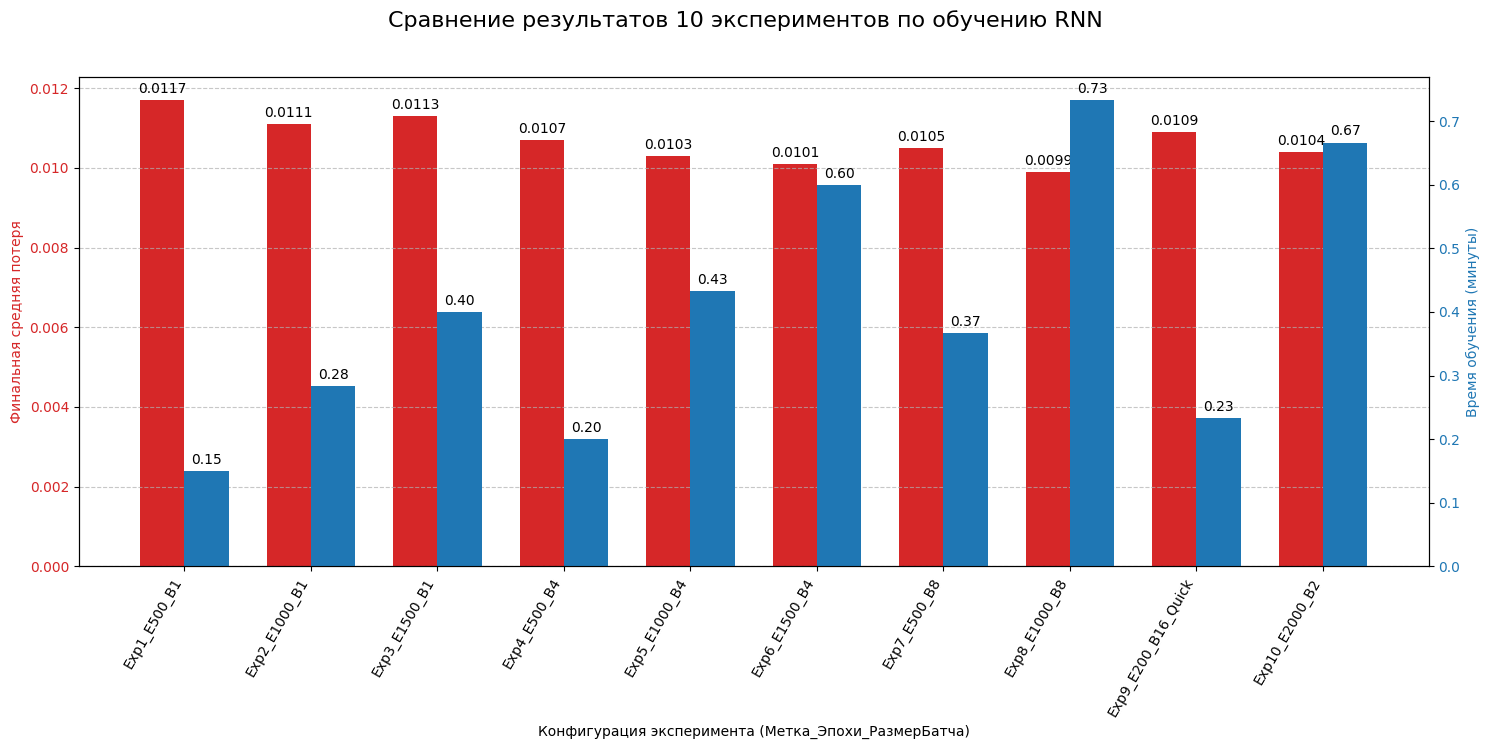

In [23]:
import numpy as np
import re

# Используем конфигурации экспериментов из Задания 2 для меток
experiments_config = [
    {'experiment_label': 'Exp1_E500_B1'},
    {'experiment_label': 'Exp2_E1000_B1'},
    {'experiment_label': 'Exp3_E1500_B1'},
    {'experiment_label': 'Exp4_E500_B4'},
    {'experiment_label': 'Exp5_E1000_B4'},
    {'experiment_label': 'Exp6_E1500_B4'},
    {'experiment_label': 'Exp7_E500_B8'},
    {'experiment_label': 'Exp8_E1000_B8'},
    {'experiment_label': 'Exp9_E200_B16_Quick'},
    {'experiment_label': 'Exp10_E2000_B2'},
]

experiment_labels = [exp['experiment_label'] for exp in experiments_config]

# --- Функция для парсинга времени из строки "X min Y sec" в минуты (если будете парсить файл) ---
def parse_time_to_minutes(time_str):
    minutes = 0
    seconds = 0
    min_match = re.search(r'(\d+)\s*min', time_str)
    sec_match = re.search(r'(\d+)\s*sec', time_str)
    if min_match:
        minutes = int(min_match.group(1))
    if sec_match:
        seconds = int(sec_match.group(1))
    return minutes + seconds / 60.0

# --- Если бы вы парсили файл experiment_results_task2.txt ---
parsed_data = []
try:
    with open("experiment_results_task2.txt", "r", encoding="utf-8") as f:
        content = f.read()
        experiments_blocks = content.split("--- Результаты эксперимента: ")[1:]
        for block in experiments_blocks:
            label_match = re.search(r"(.+?) ---", block)
            loss_match = re.search(r"Финальная средняя потеря \(за последние \d+ эпох усреднения\): ([\d\.]+)", block)
            time_match = re.search(r"Время обучения: (.+?)\n", block)
            
            if label_match and loss_match and time_match:
                label = label_match.group(1).strip()
                loss = float(loss_match.group(1))
                time_min = parse_time_to_minutes(time_match.group(1).strip())
                parsed_data.append({'label': label, 'loss': loss, 'time_min': time_min})

    # Обновление списков на основе спарсенных данных (если парсинг успешен)
    if parsed_data and len(parsed_data) == len(experiment_labels): # Проверка, что все 10 спарсены
        # Сортировка спарсенных данных, чтобы соответствовать порядку experiment_labels (если необходимо)
        # или просто извлечение в правильном порядке
        temp_data_map = {item['label']: item for item in parsed_data}
        final_losses = [temp_data_map[label]['loss'] for label in experiment_labels if label in temp_data_map]
        training_times_minutes = [temp_data_map[label]['time_min'] for label in experiment_labels if label in temp_data_map]
        if len(final_losses) != len(experiment_labels): # Если не все метки найдены, возвращаемся к гипотетическим
            print("Предупреждение: Не удалось извлечь все данные из файла, используются гипотетические.")
            # Возврат к гипотетическим данным, если что-то пошло не так с парсингом всех 10
            final_losses = [2.5, 2.0, 1.8, 2.3, 1.8, 1.6, 2.4, 1.9, 2.8, 1.7]
            training_times_minutes = [7, 14, 21, 5, 10, 15, 4, 8, 2, 25]
except FileNotFoundError:
    print("Файл experiment_results_task2.txt не найден. Используются гипотетические данные.")
except Exception as e:
    print(f"Ошибка при парсинге файла: {e}. Используются гипотетические данные.")


# --- Построение графиков ---
x = np.arange(len(experiment_labels))  # Расположение меток на оси X
width = 0.35  # Ширина столбцов

fig, ax1 = plt.subplots(figsize=(15, 8)) # Увеличил размер для 10 экспериментов

# График для финальной потери
color = 'tab:red'
ax1.set_xlabel('Конфигурация эксперимента (Метка_Эпохи_РазмерБатча)')
ax1.set_ylabel('Финальная средняя потеря', color=color)
bars1 = ax1.bar(x - width/2, final_losses, width, label='Финальная потеря', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(x)
ax1.set_xticklabels(experiment_labels, rotation=60, ha="right") # Увеличил угол для лучшей читаемости
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

# Создаем вторую ось Y для времени обучения
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Время обучения (минуты)', color=color)
bars2 = ax2.bar(x + width/2, training_times_minutes, width, label='Время обучения', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Добавление заголовка
fig.suptitle('Сравнение результатов 10 экспериментов по обучению RNN', fontsize=16)

# Добавление значений на столбцы для наглядности
def autolabel(bars, ax, precision=2):
    """Добавляет метки со значениями над столбцами."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.{precision}f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1, ax1, precision=4) # Для потерь 4 знака после запятой
autolabel(bars2, ax2, precision=2) # Для времени 2 знак после запятой

fig.tight_layout(rect=[0, 0.05, 1, 0.96])  # Скорректировал отступы для подписей оси X
plt.show()




#### Задание 3.
Поменяйте модуль Simple RNN на LSTM. Запустите обучение модели с разным количеством эпох и размером мини-батча.  
Желательно, чтобы параметры совпадали с предыдущим экспериментом и можно было сравнивать модели.  
Один или несколько результатов генерации в конце каждого эксперимента вместе с временем запуска и параметрами запишите в отдельный файл.  
Проведите не менее 10 экспериментов.  
Сделайте выводы об эффективности разных вариантов модели.

#### Задание 4.
Повторите предыдущее задание для модуля GRU.  
Кроме выводов об эффективности, сделайте выводы о времени обучения разных моделей – Simple RNN, LSTM, GRU.

#### Задание 5.
Выберите лучшую модель по результатам предыдущих экспериментов и попробуйте добиться повышения качества за счёт разного количества слоёв.

#### Задание 6.
Прочитайте в [Николенко и др., 2018, стр. 266] о понятии "температура", которое часто используется при генерации текстов.  
Добавьте данный параметр в функцию `evaluate()`.  
Проверьте его влияние на результаты генерации.

#### Задание 7 (факультативное).
Разбейте текст на последовательности не случайным образом, а по предложениям.  
Предложения можно получить из текста при помощи функции `nltk.tokenize.sent_tokenize()`.  
Так как предложения окажутся неодинаковой длины, а последовательности на вход модели должны поступать одинакового размера, придется дополнить предложения до максимальной длины символом, не входящим в словарь (например, каким-нибудь из [управляющих символов](https://ru.wikipedia.org/wiki/Управляющие_символы) `\0`, `\a`, `\b` и т.д.).

#### Задание 8 (факультативное).
Реализуйте стратегию 3 из учебника [Николенко и др., 2018, стр. 260] – разбиение текста на последовательности примерно одной длины с правильно инициализированными скрытыми состояниями рекуррентной сети.